# Notebook for analysing appetitive conditioning in the two-landmark forest with teleportation training
## Analyse all VR trials of one experimental group
## Assumes use of FlyOver version 1.0.0 or higher (closed-loop optogenetic stimulation possible)
## Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [132]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename 

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleTwoObjVRTeleportTrialAnalysis

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_2LM_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot_tele, simpleBoxPlot, \
        landmarksInSquareTile


# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['f01', 'f02', 'f03', 'f04']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
y


In [133]:
# Uncomment, if you want to select a specific subset of flies (e.g. good learners..)
#my_indices = [0,2,3]
#expDirs = itemgetter(*my_indices)(expDirs)

selectionTag = ''#_active'  # chose small string, to specify dataset (e.g. top5 flies)

In [134]:
expDirs=expDirs[:20]
print(expDirs)

['f01', 'f02', 'f03', 'f04']


In [135]:
%matplotlib inline

### Compose mutli-fly data into dataframe

In [136]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

In [137]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [138]:
genotype = dataDir.split(sep)[-6]
condition = dataDir.split(sep)[-3]
print(genotype)
print(condition)

Gr43a-KI_x_10xChrimsonR
mixCtrl


In [139]:
keylist = ['headingAngle','rotVelo','time','transVelo',
           'xPos','yPos','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','condition','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = currExpDir
        stimT = fileToAnalyse.split('_')[8]
        
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleTwoObjVRTeleportTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'train' in fileToAnalyse:
            trialtype = 'train'
            rZones = 'on'
        else:
            trialtype = 'post'
            rZones = 'off'
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'condition', condition)
        FODatLoad_df.insert(5, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/Gr43a-KI_x_10xChrimsonR/female_24h/500ms_15mm_05s_14-5mm_20min/mixCtrl/rawData/f01/

 Analysing the following log files:

['twoObjTele-10mm05s_1cm4cmConez1R_08cm3cmCyliz2_mixCtrl_6-8d_Gr43ax10xChrR-WTB_500ms_f01_post_180805162224.txt', 'twoObjTele-14-5mm05s_1cm4cmConez1R_08cm3cmCyliz2_mixCtrl_6-8d_Gr43ax10xChrR-WTB_500ms_f01_train_180805160155.txt']
Data file: 
/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/Gr43a-KI_x_10xChrimsonR/female_24h/500ms_15mm_05s_14-5mm_20min/mixCtrl/rawData/f01/twoObjTele-10mm05s_1cm4cmConez1R_08cm3cmCyliz2_mixCtrl_6-8d_Gr43ax10xChrR-WTB_500ms_f01_post_180805162224.txt

500ms_15mm_05s_14-5mm_20min fly "f01" in twoObjTele-10mm05s of 1cm4cmConez1R and 08cm3cmCyliz2
post trial

 
 Analysis ran successfully. 
 

Ran analysis, now loading saved *.npy file.
Data file: 
/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/teleOpto/Gr43a-KI_

In [140]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df

,flyID,trial,trialtype,reinforcement,condition,moving,headingAngle,rotVelo,time,transVelo,xPos,yPos,rEvents
0,f01,1.0,post,off,mixCtrl,1.0,6.395358e-07,-0.870290,0.000000,11.093072,0.000000,0.000000,0.0
1,f01,1.0,post,off,mixCtrl,1.0,-4.351850e-02,-1.521716,0.050005,5.672950,0.554405,-0.018482,0.0
2,f01,1.0,post,off,mixCtrl,1.0,-1.196124e-01,-0.868828,0.100011,6.561884,0.834737,0.024957,0.0
3,f01,1.0,post,off,mixCtrl,1.0,-1.630584e-01,-0.326801,0.150016,10.389732,1.126210,-0.125749,0.0
4,f01,1.0,post,off,mixCtrl,1.0,-1.794002e-01,-0.542748,0.200021,9.673237,1.630350,-0.251315,0.0
5,f01,1.0,post,off,mixCtrl,1.0,-2.065405e-01,-0.328271,0.250027,13.148032,2.104390,-0.347569,0.0
6,f01,1.0,post,off,mixCtrl,1.0,-2.229558e-01,-0.541298,0.300032,10.392579,2.737540,-0.524742,0.0
7,f01,1.0,post,off,mixCtrl,1.0,-2.500237e-01,-0.653609,0.350037,12.454942,3.249240,-0.615489,0.0
8,f01,1.0,post,off,mixCtrl,1.0,-2.827076e-01,-0.652341,0.400043,10.063608,3.849392,-0.781966,0.0
9,f01,1.0,post,off,mixCtrl,1.0,-3.153281e-01,-0.762841,0.450048,15.209594,4.352404,-0.796922,0.0


In [141]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID'].values).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

In [142]:
keyind_mov = keylistLong.index('moving')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_EV = keylistLong.index('rEvents')

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [143]:
# Two object reinforcement test
rZoneState = ['on','off']
trialName = ['train','post']
gridSize = 60.0

fps = 20.0 # after downsampling

coneColor = 'mediumseagreen'
cyliColor = 'mediumorchid'

LMCols = [coneColor,cyliColor]

visitRad = 15
# Use 15 mm as standard visit radius with two-landmark forest world, where
# LM are at least 60 mm separated.

coneCoords = [[gridSize/2, gridSize/2],
              [-gridSize/2, -gridSize/2]]
cyliCoords = [[gridSize/2, -gridSize/2],
              [-gridSize/2, gridSize/2]]

LMcoords = [coneCoords,cyliCoords]
LMnames = ['Cone', 'Cyli']
numLM = len(LMnames)

### Count visits

In [144]:
visitFreq = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitCount = np.nan*np.ones((numLM, len(flyIDs), len(trialName)))
visitLength = np.zeros((numLM, len(flyIDs), len(trialName)))

for fly in range(len(flyIDs)):
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        time = FOAllFlies_df.query(querystring)['time'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                           np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],time,visitRad)
        
            visitFreq[obj,fly,trial] = np.sum(entries)/(time[-1]/60.0)
            visitCount[obj,fly,trial] = np.sum(entries)
            visitLength[obj,fly,trial] = np.sum(visitT)

### Trajectory plots of all trials

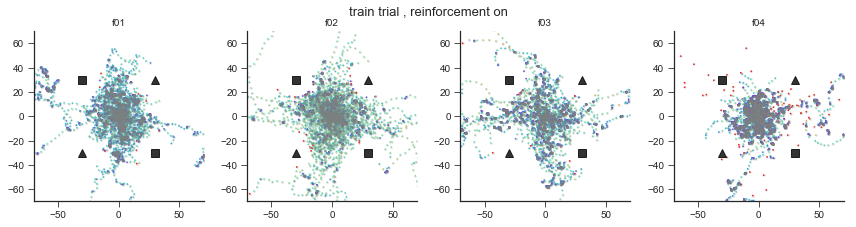

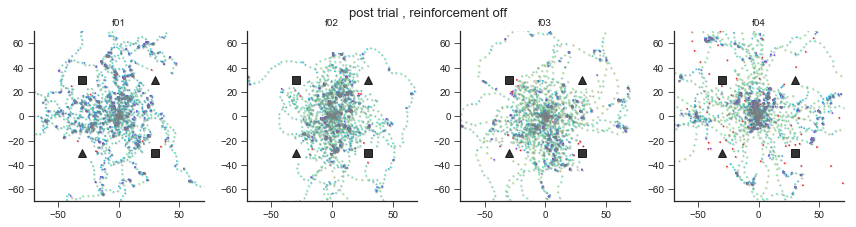

In [145]:
nrows = np.ceil(numFlies/4.0)
for ttind,trialtype in enumerate(trialName):
    multiflyTracePlot = plt.figure(figsize=(12,3*nrows))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' trial , reinforcement ' + rZoneState[ttind] ,fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(nrows,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        perFlyY = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values.squeeze()
        
        selectPts = range(0,len(perFlyX),5)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        
        landmarksInSquareTile(multiflyTracePlot_sbplt,LMcoords,['black','black'])

        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-(10 + gridSize), gridSize + 10)
        multiflyTracePlot_sbplt.set_ylim(-(10 + gridSize), gridSize + 10)
        
    multiflyTracePlot.tight_layout()
    
    multiflyTracePlot.savefig(analysisDir +'tracePlot/'+ genotype +'_'+flyIDs[0][0] +'_'+ trialtype +'_trial'+ rZoneState[ttind]
                              +'_traceVeloColored_trial'+ str(ttind+1) +'_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity distributions

In [146]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 30

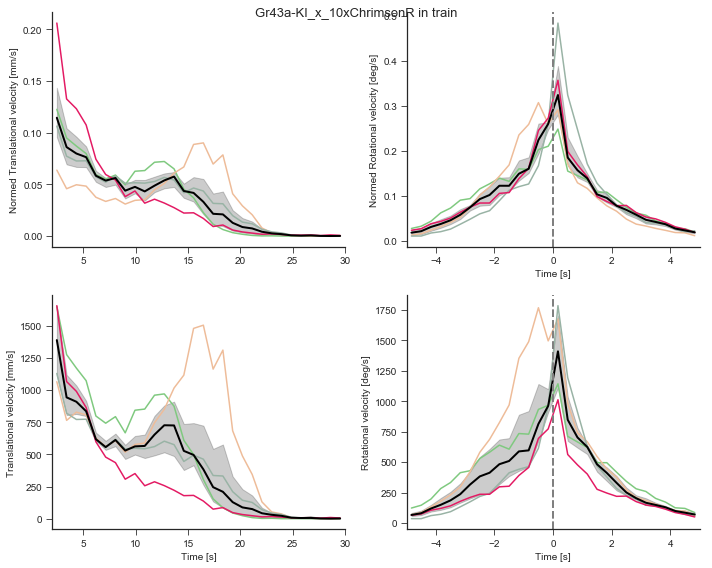

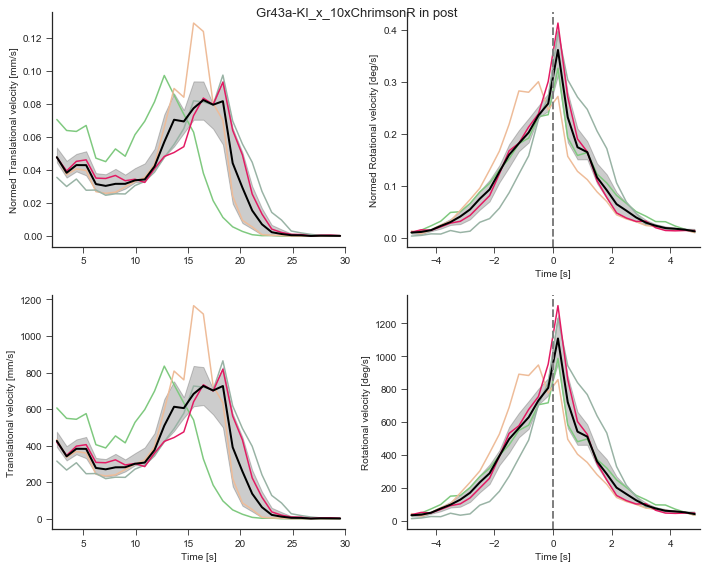

In [147]:
for tind, tname in enumerate(trialName):
    scene_df = FOAllFlies_df.query('trialtype == "' + tname + '"')
    titleString = genotype+' in '+ tname
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, keyind_mov, keyind_vT, keyind_vR, flyCMap,
                                 histRangeVT, histRangeVR,numBins, numFlies)
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotype + '_walingVelocities_'+tname+\
                       '_medianIQR_n'+str(numFlies)+selectionTag+'.pdf', format = 'pdf')

## Residency

### 2D (cartesian) residency

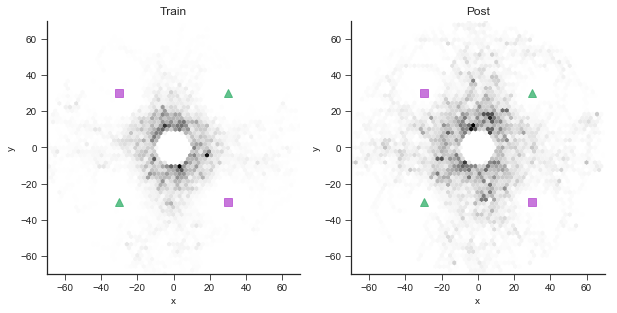

In [148]:
# plot parameter
numBins = 60

maxDist = gridSize+10
minDist = 10

hexplotfig = plt.figure(figsize=(10,5))
for trial, condition in enumerate(trialName):
    querystring = '(trialtype == "' + condition + '") & (moving > 0)'
    xPos = np.asarray(FOAllFlies_df.query(querystring)['xPos'].values)
    yPos = np.asarray(FOAllFlies_df.query(querystring)['yPos'].values)
    
    dist = np.hypot(xPos,yPos)
    slct = np.logical_and(dist<maxDist, dist>=minDist)

    ax = hexplotfig.add_subplot(1,len(trialName),trial+1)
    ax.hexbin(xPos[slct], yPos[slct], gridsize=numBins, cmap='Greys', vmin=0, linewidths=0)
    plt.xlabel('x'); plt.ylabel('y')
    
    landmarksInSquareTile(ax,LMcoords,LMCols)
            
    ax.set_title(trialName[trial].capitalize())
    ax.set_xlim(-maxDist,maxDist)
    ax.set_ylim(-maxDist,maxDist)
    
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')
hexplotfig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_residencyMA_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### 1D radial residency close around objects

In [149]:
resdf_keylist_short = ['flyID','trial','trialtype','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2cone','dist2cyli']
residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)

for trial, trialtype in enumerate(trialName):
    for fly in range(len(flyIDs)):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPos = FOAllFlies_df.query(querystring)['xPos'].values
        yPos = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPos-coneCoords[0][0]),(yPos-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPos-coneCoords[1][0]),(yPos-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPos-cyliCoords[0][0]),(yPos-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPos-cyliCoords[1][0]),(yPos-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2cone', dist2closestCone)
        tmpdf.insert(2,'dist2cyli', dist2closestCyli)
        
        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

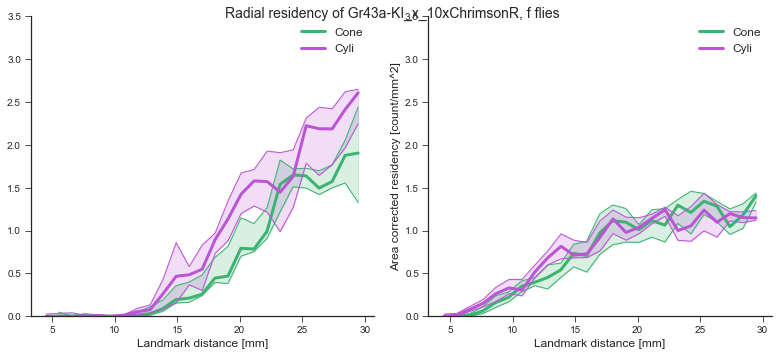

In [150]:
movementFilter = 'moving > 0'
histMax = (30,30)
histMin = (5,4) # adjust to LM base width
numBins = (25, 26)
varStyle = 'iqr' #'std', 'iqr'

keyind_dCone = resdf_keylist.index('dist2cone')
keyind_dCyli = resdf_keylist.index('dist2cyli')

# linear residency
radResFig = plt.figure(figsize=(11,5))
radResFig = oneDimResidencyWithVar_2LM_df(radResFig, residency_df, flyIDs, trialName,keyind_dCone, keyind_dCyli,
                                          movementFilter, numBins, histMin, histMax, 1, varStyle, LMCols, LMnames)
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)
radResFig.tight_layout()

radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                   +'_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Visit-based analysis

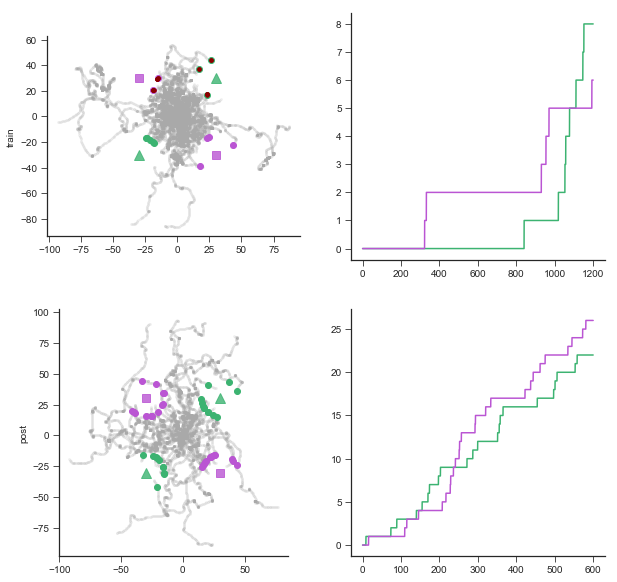

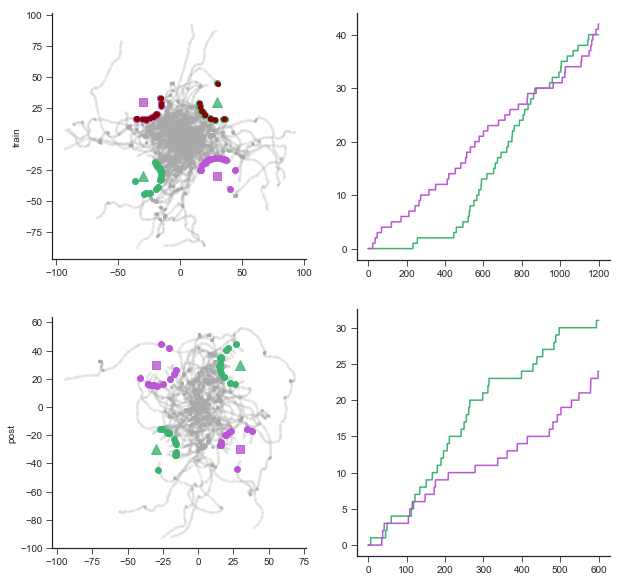

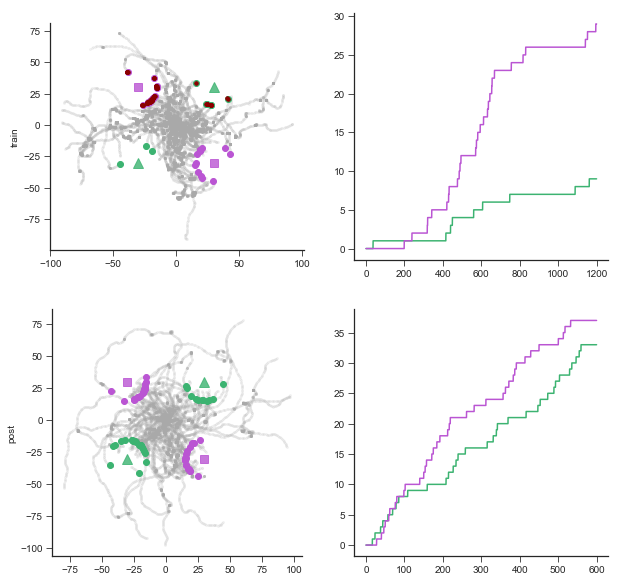

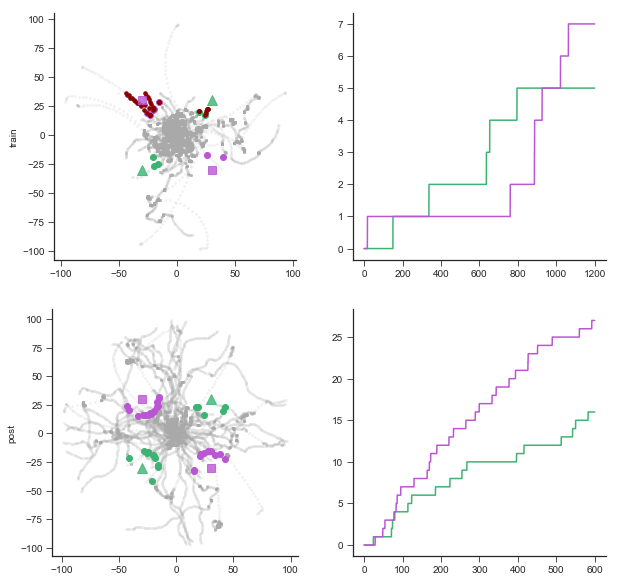

In [151]:
makePlots = True

coneVisitFreq = np.zeros((len(flyIDs),len(trialName)))
cyliVisitFreq = np.zeros((len(flyIDs),len(trialName)))

coneVisitCount = np.zeros((len(flyIDs),len(trialName)))
cyliVisitCount = np.zeros((len(flyIDs),len(trialName)))

coneVisitLength = np.zeros((len(flyIDs),len(trialName)))
cyliVisitLength = np.zeros((len(flyIDs),len(trialName)))


# Plot individual traces
if exists(analysisDir + 'reinforcementEffect/'):
    if not exists(analysisDir + 'reinforcementEffect/individualFlies/'):
        mkdir(analysisDir + 'reinforcementEffect/individualFlies/')
else:
    mkdir(analysisDir + 'reinforcementEffect/')
    mkdir(analysisDir + 'reinforcementEffect/individualFlies/')

for fly in range(len(flyIDs)):
    if makePlots:
        visitFig = plt.figure(figsize=(10,10))
        gs = gridspec.GridSpec(len(trialName),2,width_ratios=[1,1])

    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values
    
        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial,visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial,visitRad)

        if makePlots:
            visitPlt = visitFig.add_subplot(gs[trial,0])
            visitPlt.plot(xPosTrial,yPosTrial,'.',color='darkgrey',markersize=4,alpha=0.1)
            visitPlt.plot(xPosTrial[entriesCone>0],yPosTrial[entriesCone>0],'o',color=coneColor)
            visitPlt.plot(xPosTrial[entriesCyli>0],yPosTrial[entriesCyli>0],'o',color=cyliColor)

            visitPlt.plot(xPosTrial[evTrial>90],yPosTrial[evTrial>90],'.',markersize=7,color='darkred')

            for obj in range(2):
                visitPlt.plot(cyliCoords[obj][0], cyliCoords[obj][1], marker='s', markersize=8, alpha=0.8, color=cyliColor)
                visitPlt.plot(coneCoords[obj][0], coneCoords[obj][1], marker='^', markersize=10, alpha=0.8, color=coneColor)

            visitPlt.set_aspect('equal')
            visitPlt.set_ylabel(trialtype)
            myAxisTheme(visitPlt)

            cumsumVisitPlt = visitFig.add_subplot(gs[trial,1])
            cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCone),color=coneColor)
            cumsumVisitPlt.plot(timeTrial,np.cumsum(entriesCyli),color=cyliColor)
            myAxisTheme(cumsumVisitPlt)
        
        coneVisitFreq[fly,trial] = np.sum(entriesCone)/(timeTrial[-1]/60.0)
        cyliVisitFreq[fly,trial] = np.sum(entriesCyli)/(timeTrial[-1]/60.0)
        
        coneVisitCount[fly,trial] = np.sum(entriesCone)
        cyliVisitCount[fly,trial] = np.sum(entriesCyli)
        
        coneVisitLength[fly,trial] = np.sum(visitTCone)
        cyliVisitLength[fly,trial] = np.sum(visitTCyli)
    
    if makePlots:
        visitFig.savefig(analysisDir + 'reinforcementEffect/individualFlies/'+ genotype +'_'+flyIDs[0][0]
                           +'_effectOnVisits_visitRad'+str(visitRad)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

Plot directory already exists


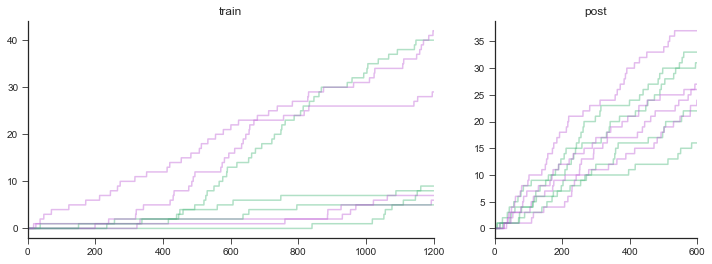

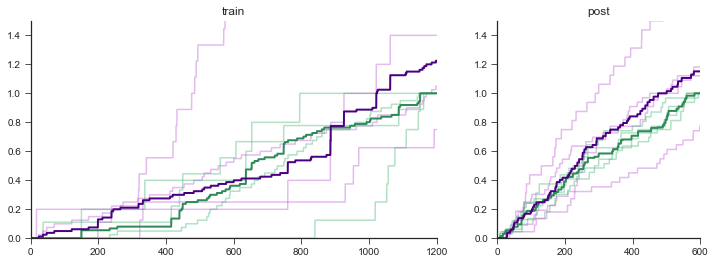

In [152]:
avLineCol = ['seagreen','indigo']

visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

alphaVal = 0.4

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    scaledVisits = np.nan*np.ones((numLM, numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        timeTrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        
        # compute distance to closest landmark for each type
        dist2closest = np.nan*np.ones( (numLM, len(xPosTrial)) )
        
        LMentries = np.zeros((numLM,len(timeTrial)))
        
        for obj in range(numLM):
            dist2closest[obj,:] = np.minimum( np.hypot((xPosTrial-LMcoords[obj][0][0]),(yPosTrial-LMcoords[obj][0][1])),
                                           np.hypot((xPosTrial-LMcoords[obj][1][0]),(yPosTrial-LMcoords[obj][1][1])) )
            
            entries,exits,visitT,entryTime,exitTime = countvisits(dist2closest[obj,:],timeTrial, visitRad)
            LMentries[obj,:] = entries
        
        
        for obj in range(numLM):
            #plot results
            cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:]),color=LMCols[obj], alpha=alphaVal)
            scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(LMentries[obj,:])/sum(LMentries[0,:]),color=LMCols[obj], alpha=alphaVal)

            scaledVisits[obj, fly,:] = np.cumsum(LMentries[obj,:])/sum(LMentries[0,:])

    for obj in range(numLM):
        #plot averages
        scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledVisits[obj,:,:].squeeze(),axis=0),
                                          color = avLineCol[obj],linewidth=2)

    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)
        
try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Selection of flies for analysis based on landmark visits

In [153]:
# minimum amount of visits to any landmark in any trial to be considered in ananlysis
minVisit = 5

notEnoughVistis = np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)<2)[0]
keepflies = list(np.where(np.sum((coneVisitCount[:,:] + cyliVisitCount[:,:])> minVisit, axis=1)>=2)[0])

# median # visits during training in group of flies that performed minimum amount of visits:
keepMedian = np.median(coneVisitCount[keepflies,1])

# split flies to keep along the median
aboveMedian = list(set(np.where(coneVisitCount[:,1]>keepMedian)[0]).intersection(set(keepflies)))
belowMedian = list(set(np.where(coneVisitCount[:,1]<=keepMedian)[0]).intersection(set(keepflies)))

In [154]:
print('Out of {} measured flies, {} made less than {} landmark visits in at least one of the three trials ({}%).\n').format(numFlies,
     len(notEnoughVistis), minVisit, 100*len(notEnoughVistis)/numFlies)
print('The remaining {} flies can be split along the median of {} visits:').format(len(keepflies), keepMedian)
print('Above median:')
print(aboveMedian)
print('Below or equal to median:')
print(belowMedian)

Out of 4 measured flies, 0 made less than 5 landmark visits in at least one of the three trials (0%).

The remaining 4 flies can be split along the median of 26.5 visits:
Above median:
[1, 2]
Below or equal to median:
[0, 3]


## Visit count plots
### Shared settings for plots

In [155]:
# Settings for boxplots of all three trials:

objBoxColors = [['seagreen','mediumseagreen'],
                ['darkmagenta','mediumorchid']] #for spec. objects
BoxColors = ['slateblue','royalblue'] # for ratio between objects

trialColors = ['darkviolet','teal']
trialMarkers = ['*','o']

offsets = [1.3, 1.3]

boxalpha = 0.5
linealpha=0.5

allTrialFigSize = (12,4)
twoTrialFigSize = (16,4)

# Settings for boxplots of pre and post trial only
objBoxColors_pp = [['lightgreen','mediumseagreen'],
                   ['palevioletred','mediumorchid']]
BoxColors_pp = ['grey','royalblue'] 
offsets_pp = [1.32, 0.68]

### Visit count and visit frequency

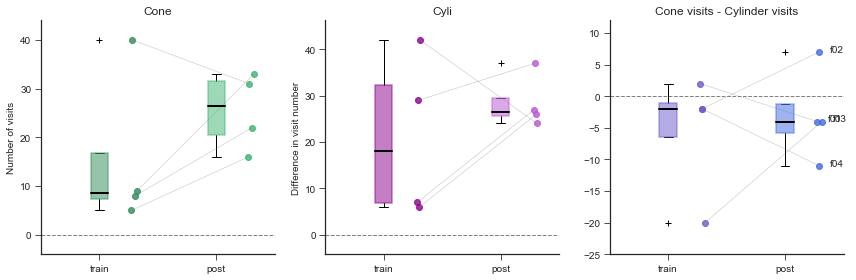

In [156]:
bpFig = plt.figure(figsize=allTrialFigSize)

VisitCountRatio = visitCount[0,:]-visitCount[1,:]

for objtype in range(len(LMnames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    objBoxPlt = prettyBoxPlot_tele(bpPlt, objBoxColors[objtype], boxalpha, linealpha, visitCount[objtype],
                              flyIDs, offsets, trialName, plotLabels=False)

    objBoxPlt.set_ylabel('Number of visits')
    bpPlt.set_title(LMnames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot_tele(bpPlt, BoxColors, boxalpha, linealpha, VisitCountRatio, flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-5+np.min(VisitCountRatio),5+np.max(VisitCountRatio)))
objBoxPlt.set_ylabel('Difference in visit number')
bpPlt.set_title('Cone visits - Cylinder visits')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

p = 0.957533620436
Plot directory already exists


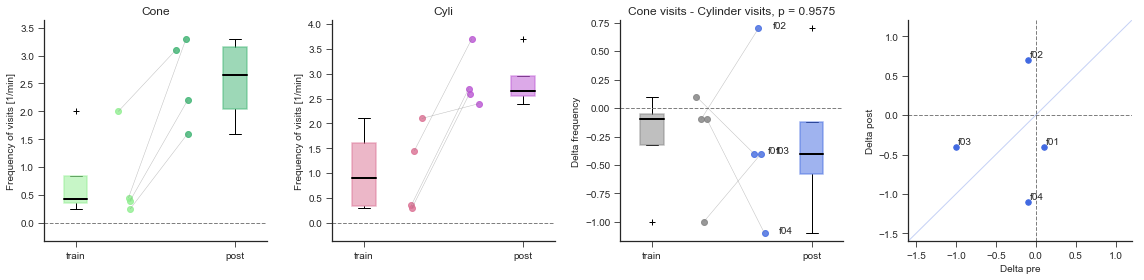

In [157]:
# compare just pre and post

VisitFreqRatio = visitFreq[0,:]-visitFreq[1,:]

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(LMnames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot_tele(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, visitFreq[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Frequency of visits [1/min]')
    bpPlt.set_title(LMnames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot_tele(bpPlt, BoxColors_pp, boxalpha, linealpha, 
                            VisitFreqRatio, flyIDs, offsets_pp, trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitFreqRatio)+np.min(VisitFreqRatio),
                0.1*np.max(VisitFreqRatio)+np.max(VisitFreqRatio)))
bpPlt.set_ylabel('Delta frequency')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitFreqRatio[:,0], VisitFreqRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitFreqRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitFrequency_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

### Visit frequency over time (5 min blocks)

In [158]:
#Adjust to trial length
blockL = 5
trial5min = [int(20/blockL),int(10/blockL)]

BoxColors_5min = [[BoxColors[i]]*trial5min[i] for i in range(len(trialName))]
blockNames_5min = [[trialName[i]+' '+ str(t+1) for t in range(trial5min[i])]  for i in range(len(trialName))]
objBoxColors_5min_1 = [[objBoxColors[0][i]]*trial5min[i] for i in range(len(trialName))]
objBoxColors_5min_2 = [[objBoxColors[1][i]]*trial5min[i] for i in range(len(trialName))]
BoxColors_5min = [item for sublist in BoxColors_5min for item in sublist]
blockNames_5min = [item for sublist in blockNames_5min for item in sublist]
objBoxColors_5min = [[item for sublist in objBoxColors_5min_1 for item in sublist],
                    [item for sublist in objBoxColors_5min_2 for item in sublist]]

In [159]:
# Generate landmark visit count over 5 min blocks
visitCount_5min = np.zeros((len(LMnames), len(flyIDs), sum(trial5min)))
visitLength_5min = np.zeros((len(LMnames), len(flyIDs), sum(trial5min)))

for fly in range(len(flyIDs)):
    blockcount = 0
    
    for trial in range(len(trialName)):
        trialtype =trialName[trial]

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)

        for block in range(trial5min[trial]):
            entriesCone,_,visitTCone,_,_ = countvisits(dist2closestCone[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], visitRad)
            entriesCyli,_,visitTCyli,_,_ = countvisits(dist2closestCyli[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], timeTrial[int(block*(fps*60*5+1)):int((block+1)*fps*60*5)], visitRad)

            visitCount_5min[0, fly, block+blockcount] = np.sum(entriesCone)
            visitCount_5min[1, fly, block+blockcount] = np.sum(entriesCyli)

            visitLength_5min[0, fly, block+blockcount] = np.sum(visitTCone)
            visitLength_5min[1, fly, block+blockcount] = np.sum(visitTCyli)
            
        blockcount = blockcount + trial5min[trial]

Plot directory already exists


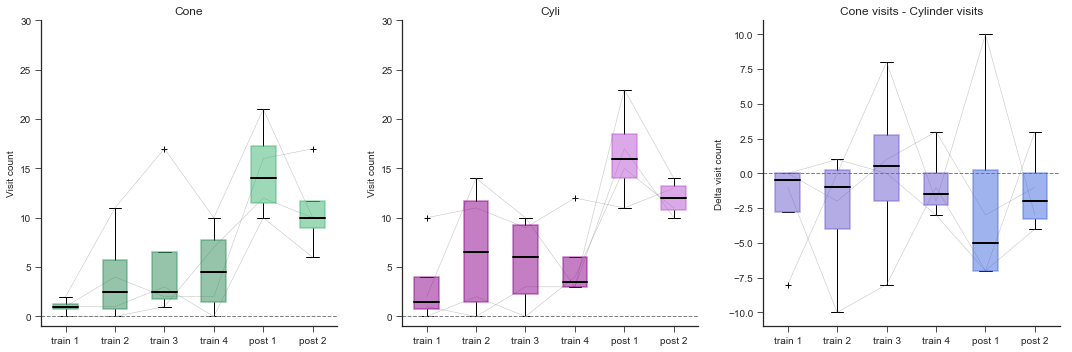

In [160]:
visitCountRatio_5min = visitCount_5min[0,:,:] - visitCount_5min[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(len(LMnames)):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitCount_5min[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit count')
    axs[objtype].set_title(LMnames[objtype])
    axs[objtype].set_ylim(-1,30)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitCountRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((np.min(visitCountRatio_5min)-1,np.max(visitCountRatio_5min)+1))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit count')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitCount5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

Plot directory already exists


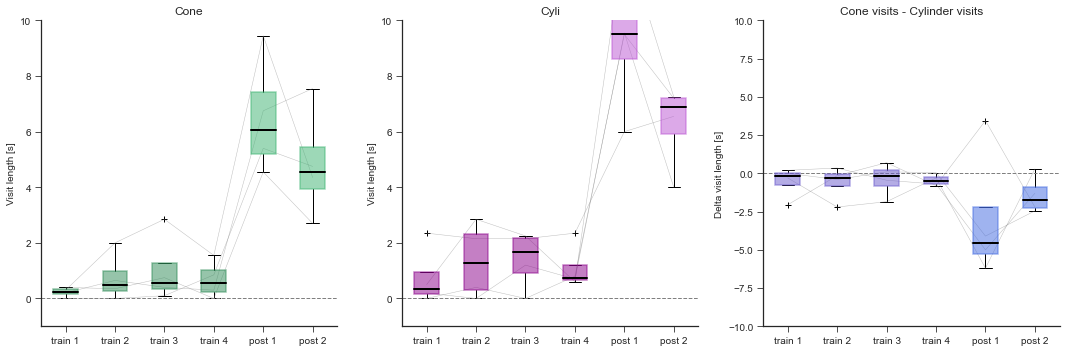

In [161]:
visitLength_5min_nan = visitLength_5min.copy()
visitLength_5min_nan[np.isnan(visitLength_5min_nan)] = 0

visitLengthRatio_5min = visitLength_5min_nan[0,:,:] - visitLength_5min_nan[1,:,:]

bpFig, axs = plt.subplots(1,3,figsize=(15,5))

for objtype in range(len(LMnames)):    
    objBoxPlt = simpleBoxPlot(axs[objtype], objBoxColors_5min[objtype], boxalpha, linealpha, 
                              visitLength_5min_nan[objtype,:,:], flyIDs, blockNames_5min)

    axs[objtype].set_ylabel('Visit length [s]')
    axs[objtype].set_title(LMnames[objtype])
    axs[objtype].set_ylim(-1,10)

ratioBoxPlt = simpleBoxPlot(axs[2], BoxColors_5min, boxalpha, linealpha, visitLengthRatio_5min, flyIDs,
                            blockNames_5min)

axs[2].set_ylim((-10, 10))
axs[2].set_title('Cone visits - Cylinder visits')
axs[2].set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
                 +'_visitLength5min_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

## Effect of reinforcement on walking velocity

Plot directory already exists


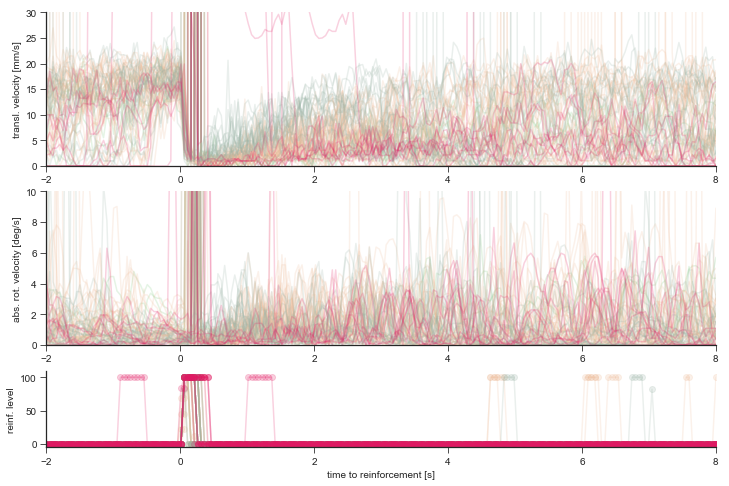

In [162]:
trialtype ='train'
 
rewardEffectFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,1,height_ratios=[1,1,0.5])

rewardVTPlt = rewardEffectFig.add_subplot(gs[0])
rewardVRPlt = rewardEffectFig.add_subplot(gs[1])
rewardEVPlt = rewardEffectFig.add_subplot(gs[2])
    
for fly in range(numFlies):
    flyCol = flyCMap.to_rgba(fly)
    querystring = '(trialtype=="' + trialtype + '") & (flyID =="' + flyIDs[fly] +  '")'
    
    perFlyX = FOAllFlies_df.query(querystring)['xPos'].values
    perFlyY = FOAllFlies_df.query(querystring)['yPos'].values
    perFlyvT = FOAllFlies_df.query(querystring)['transVelo'].values
    perFlyvR = FOAllFlies_df.query(querystring)['rotVelo'].values
    perFlyEv = FOAllFlies_df.query(querystring)['rEvents'].values

    evTimes = np.where(perFlyEv>80)[0]
    evStarts = np.where(np.diff(perFlyEv)>0)[0]

    postWindow = 160
    preWindow = 40
    timeLine = np.linspace(-preWindow*1/fps,postWindow*1/fps,preWindow+postWindow)
    for evStart in evStarts:
        evStart = evStart
        if (evStart+postWindow > len(perFlyvT) or evStart-preWindow < 0):
            continue
        rewardVTPlt.plot(timeLine,perFlyvT[evStart-preWindow:evStart+postWindow],color=flyCol,alpha=0.2)
        rewardVRPlt.plot(timeLine,abs(perFlyvR[evStart-preWindow:evStart+postWindow]),color=flyCol,alpha=0.2)
        rewardEVPlt.plot(timeLine,perFlyEv[evStart-preWindow:evStart+postWindow],'o-',color=flyCol,alpha=0.2)

rewardVTPlt.set_ylim(0,30)
rewardVTPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVTPlt.set_ylabel('transl. velocity [mm/s]')
myAxisTheme(rewardVTPlt)

rewardVRPlt.set_ylim(0,10)
rewardVRPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardVRPlt.set_ylabel('abs. rot. velocity [deg/s]')
myAxisTheme(rewardVRPlt)

rewardEVPlt.set_ylim(-5,110)
rewardEVPlt.set_xlim(-preWindow*1/fps,postWindow*1/fps)
rewardEVPlt.set_ylabel('reinf. level')
rewardEVPlt.set_xlabel('time to reinforcement [s]')
myAxisTheme(rewardEVPlt)


try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
rewardEffectFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                   +'_velocityRespToReinf_n'+ str(len(flyIDs))+selectionTag+'.pdf', format='pdf')

## Analysis of trajectory segments defined by teleportation events

In [164]:
try:
    mkdir(analysisDir + 'teleportRuns/')
except:
    print('Plot directory already exists')
    
def drawTeleRad(ax, LMcoord, rad):
    for LM in range(len(LMcoord)):
        for i in range(2):
            circle = plt.Circle(LMcoord[LM][i], rad, color='grey', fill=False)
            ax.add_artist(circle)

Plot directory already exists


In [165]:
trialtype = 'train'
fly = 1
querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
evtrial = FOAllFlies_df.query(querystring)['rEvents'].values
time = FOAllFlies_df.query(querystring)['time'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
    
jumpDist = 5*np.std(np.diff(dist))
jumps = np.hstack((0,np.where(np.diff(dist)<-jumpDist)[0]+1))

# remove jumps, if it directly follows an other one
jumps = np.hstack((0,jumps[np.where(np.diff(jumps)>1)[0]+1]))
len(jumps)

150

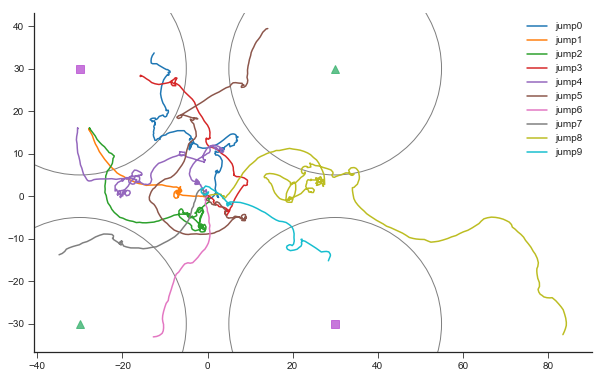

In [166]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

for i in range(0,10):
    ax.plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]])
    
ax.legend(['jump'+str(i) for i in range(10)])
landmarksInSquareTile(ax,LMcoords,LMCols)
drawTeleRad(ax, LMcoords, 25)

(-70, 70)

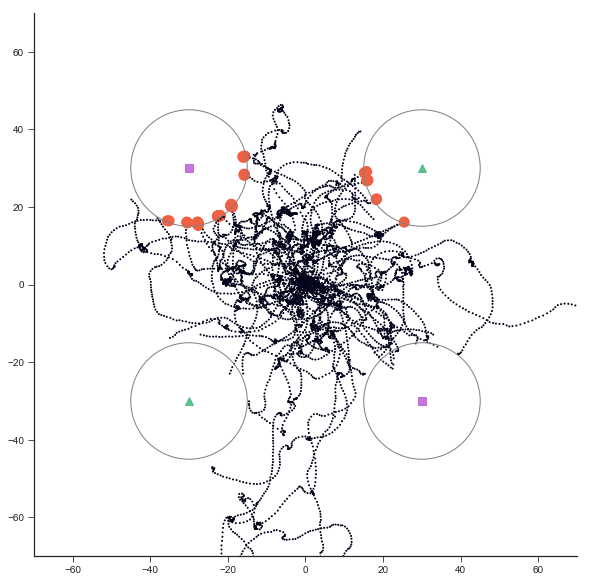

In [167]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
for i in range(0,50):
    ax.scatter(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]],s=1+evtrial[jumps[i]:jumps[i+1]],
               c=evtrial[jumps[i]:jumps[i+1]], vmin=0, vmax=150)
    
landmarksInSquareTile(ax,LMcoords,LMCols)
drawTeleRad(ax, LMcoords, 15)
ax.set_xlim(-70,70)
ax.set_ylim(-70,70)

### Condition on initial heading

In [176]:
trialtype = 'train'
fly = 3
querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
xtrial = FOAllFlies_df.query(querystring)['xPos'].values
ytrial = FOAllFlies_df.query(querystring)['yPos'].values
head = FOAllFlies_df.query(querystring)['headingAngle'].values

dist = np.hypot(xtrial,ytrial)

dist2closest = np.nan*np.ones( (numLM, len(xtrial)) )

for obj in range(numLM):
    dist2closest[obj,:] = np.minimum( np.hypot((xtrial-LMcoords[obj][0][0]),(ytrial-LMcoords[obj][0][1])),
                                    np.hypot((xtrial-LMcoords[obj][1][0]),(ytrial-LMcoords[obj][1][1])) )
    
jumpDist = 5*np.std(np.diff(dist))
jumps = np.hstack((0,np.where(np.diff(dist)<-jumpDist)[0]+1))

# remove jumps, if it directly follows an other one
jumps = np.hstack((0,jumps[np.where(np.diff(jumps)>1)[0]+1]))
len(jumps)

43

cone -> cone: 0.588235294118 
 cone -> cyli: 0.235294117647 
 cyli -> cone: 0.538461538462 
 cyli -> cyli: 0.307692307692



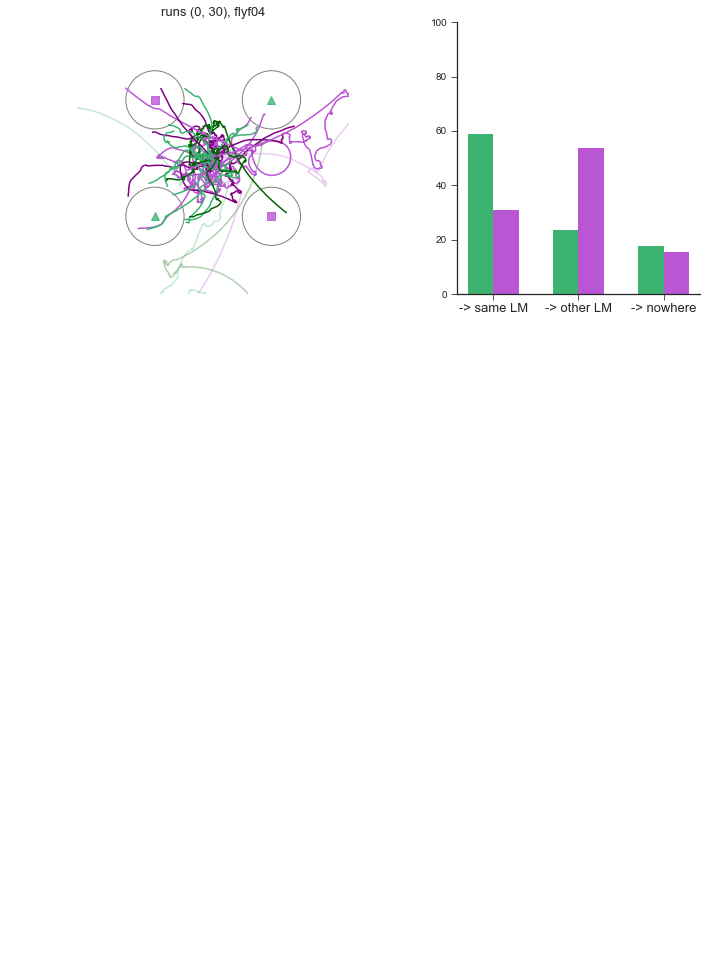

In [177]:
maxTargetDist = 25
minTargetDist = 35

jumpRanges = [(0,30), (30,60), (60,90)]

fig, ax = plt.subplots(len(jumpRanges),2,figsize=(12,17), gridspec_kw={'width_ratios':[1.5,1]})

for k, jR in enumerate(jumpRanges):

    if(jR[1]>=len(jumps)):
        ax[k, 0].axis('off')
        ax[k, 1].axis('off')
        continue
        
    condTarget = np.zeros((2,3))

    for i in range(jR[0],jR[1]):
        
        firstInSight = np.where(np.min(dist2closest[:,jumps[0]:jumps[0+1]],axis=0)<minTargetDist)[0][0]
        fovSt = head[jumps[i]+firstInSight]*180/np.pi
        
        if min(dist2closest[:, jumps[i+1]-1]) > maxTargetDist:
            targetLM = 2
            alphav=0.3
        else:
            alphav = 1
            targetLM = np.argmin(dist2closest[:, jumps[i+1]-1])

        if fovSt<=0 and fovSt >-90: # cyli
            condTarget[1,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color=LMCols[1], alpha=alphav)

        elif fovSt<=-90: #cone
            condTarget[0,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color=LMCols[0], alpha=alphav)

        elif fovSt>0 and fovSt <90: # cone
            condTarget[0,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color='darkgreen', alpha=alphav)

        else: #fovSt>0 and fovSt >90 # cyli
            condTarget[1,targetLM] +=1
            ax[k, 0].plot(xtrial[jumps[i]:jumps[i+1]],ytrial[jumps[i]:jumps[i+1]], color='purple', alpha=alphav)


    landmarksInSquareTile(ax[k, 0],LMcoords,LMCols)
    drawTeleRad(ax[k, 0], LMcoords, 15)
    ax[k, 0].axis('off')
    ax[k, 0].set_xlim(-70,70)
    ax[k, 0].set_ylim(-70,70)

    barwidth = 0.3
    fromConeFov = 100.*condTarget[0,:]/np.sum(condTarget[0,:])
    fromCyliFov = 100.*condTarget[1,:]/np.sum(condTarget[1,:])
    fromCyliFov[0] = fromCyliFov[1]
    fromCyliFov[1] = 100.*condTarget[1,0]/np.sum(condTarget[1,:])

    ind = np.arange(len(fromConeFov)) 
    ax[k, 1].bar(ind - barwidth/2, fromConeFov, width= barwidth, color=LMCols[0])
    ax[k, 1].bar(ind + barwidth/2, fromCyliFov, width= barwidth, color=LMCols[1])

    ax[k, 1].set_xticks(ind)
    ax[k, 1].set_xticklabels(('-> same LM', '-> other LM', '-> nowhere'), fontsize=13)
    ax[k, 1].set_ylim(0,100)
    myAxisTheme(ax[k, 1])
    
    ax[k, 0].set_title('runs '+str(jR)+', fly' + flyIDs[fly], fontsize=13)

    print('cone -> cone: {0} \n cone -> cyli: {1} \n cyli -> cone: {2} \n cyli -> cyli: {3}\n'.format(
          condTarget[0,0]/np.sum(condTarget[0,:]),condTarget[0,1]/np.sum(condTarget[0,:]),
        condTarget[1,0]/np.sum(condTarget[1,:]),condTarget[1,1]/np.sum(condTarget[1,:])))

#fig.suptitle('fly' + flyIDs[fly])
fig.savefig(analysisDir + 'teleportRuns/'+ genotype +flyIDs[0][0]
                +'_runEffects_minFOVDist'+str(minTargetDist)+'mm_maxTargetDist'+str(maxTargetDist)+'mm_fly'+ flyIDs[fly] +'.pdf', format='pdf')

not enough runs
not enough runs
not enough runs


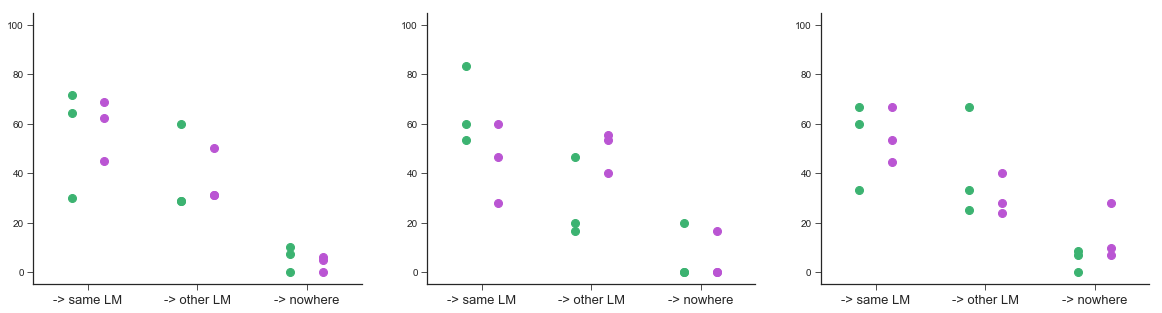

In [179]:
fig, axs = plt.subplots(1,len(jumpRanges),figsize=(20,5))

for k, jR in enumerate(jumpRanges):
    for fly in range(numFlies):
        try:
            fromConeFov = 100*allCondTarget[k,fly,0,:]/np.sum(allCondTarget[k,fly,0,:])
            fromCyliFov = 100*allCondTarget[k,fly,1,:]/np.sum(allCondTarget[k,fly,1,:])

            ind = np.arange(len(fromConeFov)) +1
            axs[k].plot(ind - 0.15, fromConeFov, 'o', color=LMCols[0], markersize=8)
            axs[k].plot(ind + 0.15, fromCyliFov, 'o', color=LMCols[1], markersize=8)
        except:
            print("not enough runs")

    axs[k].set_xticks(ind)
    axs[k].set_xticklabels(('-> same LM', '-> other LM', '-> nowhere'), fontsize=13)
    myAxisTheme(axs[k])
    axs[k].set_xlim(0.5,3.5)
    axs[k].set_ylim(-5,105)

### Run time to cone vs. cylinder

IndexError: index 2 is out of bounds for axis 1 with size 2

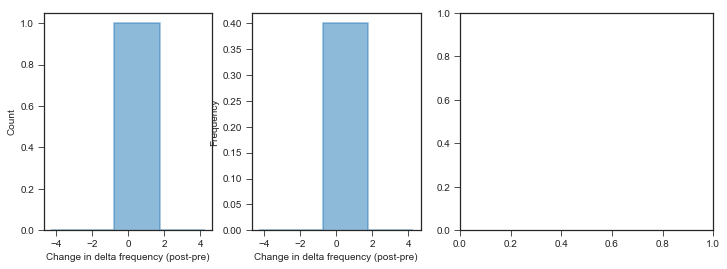

In [97]:
# Learning-induced shift in visit freuqency
histrange = (-4.25,4.25)
nbins = 17

normedvals = [False, True]
labelvals = ['Count','Frequency']

shiftFig, axs = plt.subplots(1,3,figsize=(12,4), gridspec_kw={'width_ratios':[1,1,1.5]})

for i in range(2):
    axs[i].hist(VisitFreqRatio[:,1]-VisitFreqRatio[:,0], range=histrange, bins=nbins, histtype = 'step',
                  normed=normedvals[i], fill=BoxColors_pp[-1],linewidth=1.5, align='mid', alpha=boxalpha)
    axs[i].set_xlabel('Change in delta frequency (post-pre)')
    axs[i].set_ylabel(labelvals[i])

#scatter plot of cone-change vs. cylinder-chance visits per trial
coneShift = coneVisitFreq[:,2]-coneVisitFreq[:,0]
cyliShift = cyliVisitFreq[:,2]-cyliVisitFreq[:,0]
#axs[2].plot(coneShift, cyliShift ,markersize=7,
#             marker=trialMarkers[trial],linestyle='none', color=BoxColors_pp[-1], alpha=0.8)
cb = axs[2].scatter(coneShift, cyliShift, s=coneVisitFreq[:,1]*30, c=coneVisitFreq[:,0]-cyliVisitFreq[:,0], 
               cmap='PuBu_r',vmin=-1.5, vmax=1.5, alpha=0.8, edgecolor='grey')
plt.colorbar(cb, ax=axs[2],label='cone preference')
maxplt = 0.2 + np.nanmax((coneShift, cyliShift))
minplt = -0.2 + np.nanmin((coneShift, cyliShift))
axs[2].plot([minplt,maxplt],[minplt,maxplt],linewidth=1,color='grey',linestyle='dashed',alpha=0.5)
axs[2].set_xlabel('less in post         <--->         more in post\n$\Delta$ Cone visit count (post - pre)')
axs[2].set_ylabel('$\Delta$ Cylinder visit count (post - pre)\nless in post         <--->         more in post')
axs[2].set_xlim(minplt, maxplt)
axs[2].set_ylim(minplt, maxplt)
axs[2].set_title('size: # cone visits in training')

[myAxisTheme(axs[i]) for i in range(3)]
shiftFig.tight_layout()

shiftFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitFrequency_prePostHist_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

### Visit length

Plot directory already exists


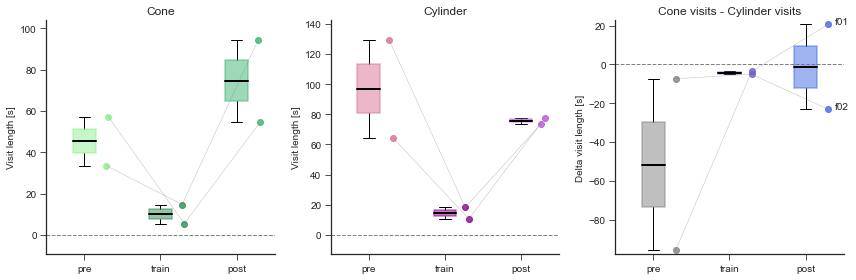

In [53]:
conelength = np.copy(coneVisitLength); cylilength = np.copy(cyliVisitLength)
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=allTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,3,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets, trialName, plotLabels=False)

    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,3,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors, boxalpha, linealpha, VisitLengthRatio,flyIDs, offsets, 
                            trialName, plotLabels=True)

bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_title('Cone visits - Cylinder visits')
bpPlt.set_ylabel('Delta visit length [s]')

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
              +selectionTag+'.pdf', format='pdf')

p = 0.584742839235
Plot directory already exists


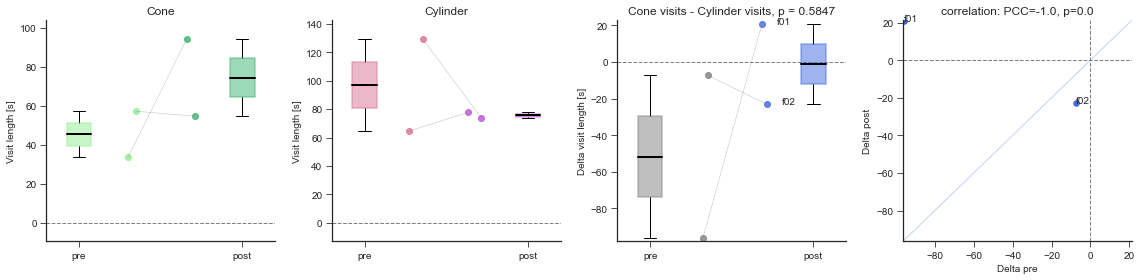

In [54]:
# compare just pre and post
conelength = np.copy(coneVisitLength[:,[0,2]]); cylilength = np.copy(cyliVisitLength[:,[0,2]])
conelength[np.isnan(conelength)] = 0; cylilength[np.isnan(cylilength)] = 0
VisitLength = [conelength,cylilength]
VisitLengthRatio = conelength-cylilength

bpFig = plt.figure(figsize=twoTrialFigSize)

for objtype in range(len(objtypeNames)):
    bpPlt = bpFig.add_subplot(1,4,objtype+1)
    
    objBoxPlt = prettyBoxPlot(bpPlt, objBoxColors_pp[objtype], boxalpha, linealpha, VisitLength[objtype],
                             flyIDs, offsets_pp, trialName, plotLabels=False)
    
    bpPlt.set_xlim((0.8,2.2))
    bpPlt.set_ylabel('Visit length [s]')
    bpPlt.set_title(objtypeNames[objtype])

bpPlt = bpFig.add_subplot(1,4,3)
ratioBoxPlt = prettyBoxPlot(bpPlt, BoxColors_pp, boxalpha, linealpha,
                            VisitLengthRatio, flyIDs, offsets_pp, trialName, plotLabels=True)

bpPlt.set_xlim((0.8,2.2))
bpPlt.set_ylim((-0.1*np.max(VisitLengthRatio)+np.min(VisitLengthRatio),
                0.1*np.max(VisitLengthRatio)+np.max(VisitLengthRatio)))
bpPlt.set_ylabel('Delta visit length [s]')

from scipy import stats as sts
tval, pval = sts.ttest_rel(VisitLengthRatio[:,0], VisitLengthRatio[:,1],
              axis=0, nan_policy='propagate')
bpPlt.set_title('Cone visits - Cylinder visits, p = ' + str(round(pval,4)))
print('p = ' + str(pval))

# correlation between pre and post prefererence 
bpPlt = bpFig.add_subplot(1,4,4)

bpPlt = diffCorrPlot(bpPlt, VisitLengthRatio, flyIDs, BoxColors_pp[-1])

bpFig.tight_layout()

try:
    mkdir(analysisDir + 'visitAnalysis/')
except:
    print('Plot directory already exists')
bpFig.savefig(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
              +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                 +selectionTag+'.pdf', format='pdf')

np.savetxt(analysisDir + 'visitAnalysis/'+ genotype +'_'+flyIDs[0][0]
           +'_visitLength_prePost_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
           +selectionTag+'.csv', VisitFreqRatio,delimiter=',')

### Cumsum visit plot

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in divide
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


Plot directory already exists


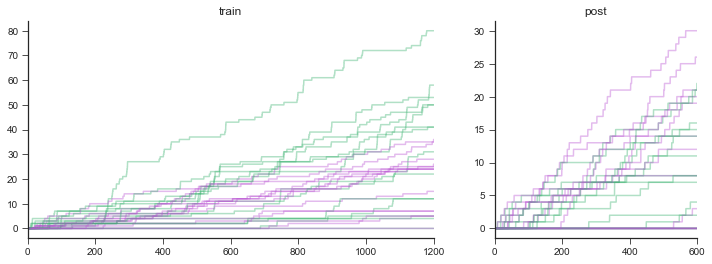

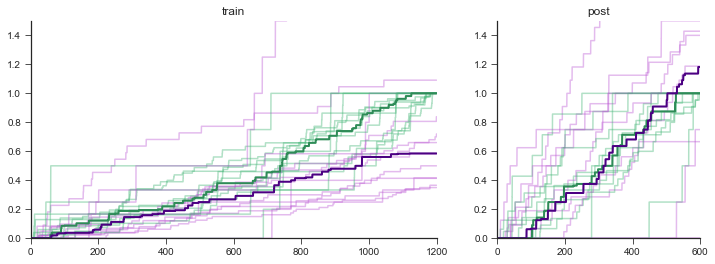

In [120]:
visitRad = 20

visitFig, cumsumVisitPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})
scaledVisitFig, scaledCumsumVisitPlts  = plt.subplots(1,len(trialName), figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring)['time'].values
    scaledConeVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    scaledCyliVisits = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):
        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone,timeTrial, visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli,timeTrial, visitRad)
            
        alphaVal = 0.4
        
        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        cumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli),color='mediumorchid', alpha=alphaVal)
        
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCone)/sum(entriesCone),color='mediumseagreen', alpha=alphaVal)
        scaledCumsumVisitPlts[trial].plot(timeTrial,np.cumsum(entriesCyli)/sum(entriesCone),color='mediumorchid', alpha=alphaVal)
        
        scaledConeVisits[fly,:] = np.cumsum(entriesCone)/sum(entriesCone)
        scaledCyliVisits[fly,:] = np.cumsum(entriesCyli)/sum(entriesCone)

    cumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitPlts[trial])
    cumsumVisitPlts[trial].set_title(trialtype)

    scaledCumsumVisitPlts[trial].set_xlim(0,max(timeTrial))
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledConeVisits,axis=0),
                                      color = 'seagreen',linewidth=2)
    scaledCumsumVisitPlts[trial].plot(timeTrial, np.nanmedian(scaledCyliVisits,axis=0),
                                      color = 'indigo',linewidth=2)
    myAxisTheme(scaledCumsumVisitPlts[trial])
    scaledCumsumVisitPlts[trial].set_title(trialtype)
    scaledCumsumVisitPlts[trial].set_ylim(0,1.5)

try:
    mkdir(analysisDir + 'reinforcementEffect/')
except:
    print('Plot directory already exists')
visitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')
scaledVisitFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_coneScaledCumVisitComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs)) +selectionTag+'.pdf', format='pdf')

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in divide


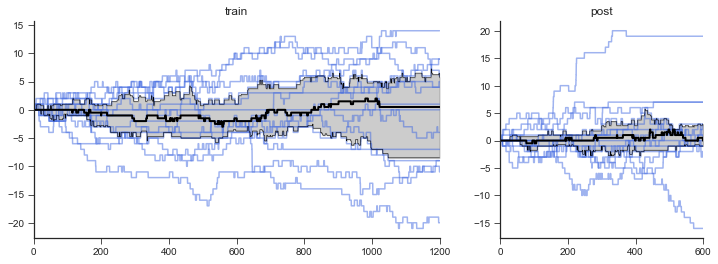

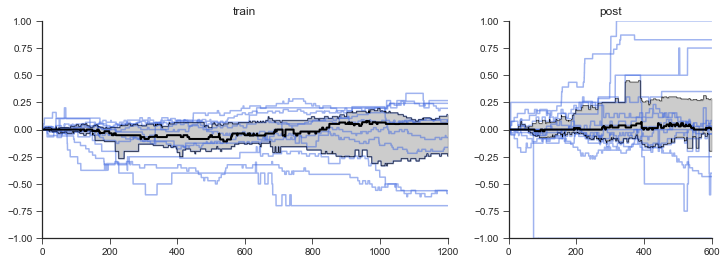

In [122]:
visitRad = 30

visitDiffFig, cumsumVisitDiffPlts = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})
scaledVisitDiffFig, scaledCumsumVisitDiffPlts  = plt.subplots(1,len(trialName), figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})

for trial in range(len(trialName)):
    trialtype = trialName[trial]
    
    querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[0]+'")'
    timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
    visitDiff = np.nan*np.ones((numFlies, len(timeTrial)))
    visitDiffNorm = np.nan*np.ones((numFlies, len(timeTrial)))
    
    for fly in range(numFlies):

        querystring = '(trialtype=="' + trialtype + '") & (flyID == "'+flyIDs[fly]+'")'
        xPosTrial = FOAllFlies_df.query(querystring)['xPos'].values
        yPosTrial = FOAllFlies_df.query(querystring)['yPos'].values
        timeTrial = FOAllFlies_df.query(querystring)['time'].values
        evTrial = FOAllFlies_df.query(querystring)['rEvents'].values

        # compute distance to each landmark
        dist2cone1 = np.hypot((xPosTrial-coneCoords[0][0]),(yPosTrial-coneCoords[0][1]))
        dist2cone2 = np.hypot((xPosTrial-coneCoords[1][0]),(yPosTrial-coneCoords[1][1]))
        dist2cyli1 = np.hypot((xPosTrial-cyliCoords[0][0]),(yPosTrial-cyliCoords[0][1]))
        dist2cyli2 = np.hypot((xPosTrial-cyliCoords[1][0]),(yPosTrial-cyliCoords[1][1]))

        # compute distance to closest landmark
        dist2closestCone = np.minimum(dist2cone1,dist2cone2)
        dist2closestCyli = np.minimum(dist2cyli1,dist2cyli2)
        
        entriesCone,exitsCone,visitTCone,entryTimeCone,exitTimeCone = countvisits(dist2closestCone, timeTrial, visitRad)
        entriesCyli,exitsCyli,visitTCyli,entryTimeCyli,exitTimeCyli = countvisits(dist2closestCyli, timeTrial, visitRad)

        visitDiff[fly] = np.cumsum(entriesCone)-np.cumsum(entriesCyli)
        visitDiffNorm[fly] = np.cumsum(entriesCone)/sum(entriesCone) - np.cumsum(entriesCyli)/sum(entriesCone)
        
        cumsumVisitDiffPlts[trial].plot(timeTrial,visitDiff[fly],color=BoxColors_pp[-1], alpha=0.5)
        
        scaledCumsumVisitDiffPlts[trial].plot(timeTrial,visitDiffNorm[fly] ,color=BoxColors_pp[-1], alpha=0.5)
    
    av = np.nanmedian(visitDiff,axis=0)
    [var1,var2] = np.nanpercentile(visitDiff, [25,75], axis=0)
    cumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    cumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    av = np.nanmedian(visitDiffNorm,axis=0)
    [var1,var2] = np.nanpercentile(visitDiffNorm,[25,75], axis=0)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,av,color='black', alpha=1, linewidth=2)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var1,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].plot(timeTrial,var2,color='black', alpha=1, linewidth=0.5)
    scaledCumsumVisitDiffPlts[trial].fill_between(timeTrial, var1, var2, color='black', alpha=0.2)
    
    cumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(cumsumVisitDiffPlts[trial])
    cumsumVisitDiffPlts[trial].set_title(trialtype)
    
    scaledCumsumVisitDiffPlts[trial].set_xlim(0,max(timeTrial))
    myAxisTheme(scaledCumsumVisitDiffPlts[trial])
    scaledCumsumVisitDiffPlts[trial].set_title(trialtype)
    scaledCumsumVisitDiffPlts[trial].set_ylim(-1,1)
        
visitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_cumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     +selectionTag+'.pdf', format='pdf')
scaledVisitDiffFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                       +'_scaledCumVisitDiffComparison_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                           +selectionTag+'.pdf', format='pdf')

## Effect of repeated reward on movement

### Quantify the effect of the total amount of reward a fly experienced on movement patterns


In [61]:
rewardT = np.zeros(len(flyIDs))
vTrans = np.zeros((len(flyIDs),len(trialName)))
vRot = np.zeros((len(flyIDs),len(trialName)))

for fly in range(len(flyIDs)):
    querystring = '(trialtype=="train") & (flyID == "'+flyIDs[fly]+'")'
    evTrial = FOAllFlies_df.query(querystring).iloc[:,keyind_EV:keyind_EV+1].values.squeeze()
    rewardT[fly] = np.sum(np.sign(evTrial))/fps
    
for fly in range(len(flyIDs)):
    for trial in range(3):
        querystring = '(trialtype=="'+trialName[trial]+'") & (flyID == "'+flyIDs[fly]+'")'
        timeTrial = FOAllFlies_df.query(querystring).iloc[:, keyind_t:keyind_t+1].values.squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].values.squeeze()
        perFlyvR = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].values.squeeze()
        perFlymov = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].values.squeeze()

        tSt = 0#(5*len(timeTrial))/10.0
        tEnd = len(timeTrial)
        vt = perFlyvT[tSt:tEnd]
        vr = perFlyvR[tSt:tEnd]
        mov = perFlymov.astype('bool')[tSt:tEnd] 
        vTrans[fly,trial] = np.squeeze(np.nanmedian(vt[mov]))
        vRot[fly,trial] = np.squeeze(np.nanmedian(abs(vr[mov])))

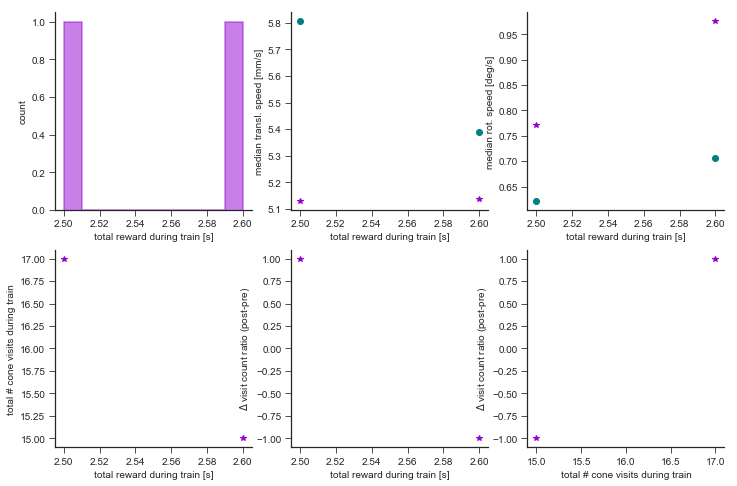

In [62]:
rewardExpFig, rewardExpAxs = plt.subplots(2,3, figsize=(12,8))

rewardExpAxs[0,0].hist(rewardT,fill=True, color=trialColors[1], alpha=boxalpha, histtype = 'step',
                      linewidth=1.5, align='mid')
rewardExpAxs[0,0].set_xlabel('total reward during train [s]')
rewardExpAxs[0,0].set_ylabel('count')

for trial in range(1,3):
    rewardExpAxs[0,1].plot(rewardT,vTrans[:,trial],marker=trialMarkers[trial],
                           linestyle='none', color=trialColors[trial])
rewardExpAxs[0,1].set_xlabel('total reward during train [s]')
rewardExpAxs[0,1].set_ylabel('median transl. speed [mm/s]')

for trial in range(1,3):
    rewardExpAxs[0,2].plot(rewardT,vRot[:,trial],marker=trialMarkers[trial],
                           linestyle='none', color=trialColors[trial])
rewardExpAxs[0,2].set_xlabel('total reward during train [s]')
rewardExpAxs[0,2].set_ylabel('median rot. speed [deg/s]')


rewardExpAxs[1,0].plot(rewardT,coneVisitCount[:,1],marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,0].set_xlabel('total reward during train [s]')
rewardExpAxs[1,0].set_ylabel('total # cone visits during train')

VisitCountRatio = coneVisitCount[:,2]-cyliVisitCount[:,0]
rewardExpAxs[1,1].plot(rewardT,VisitCountRatio,marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,1].set_xlabel('total reward during train [s]')
rewardExpAxs[1,1].set_ylabel('$\Delta$ visit count ratio (post-pre)')

rewardExpAxs[1,2].plot(coneVisitCount[:,1],VisitCountRatio,marker=trialMarkers[1],
                      linestyle='none', color=trialColors[1])
rewardExpAxs[1,2].set_xlabel('total # cone visits during train')
rewardExpAxs[1,2].set_ylabel('$\Delta$ visit count ratio (post-pre)')

for i in range(2):
    [myAxisTheme(rewardExpAxs[i,j]) for j in range(3)]
    
rewardEffectFig.tight_layout()

rewardExpFig.savefig(analysisDir + 'reinforcementEffect/'+ genotype +'_'+flyIDs[0][0]
                 +'_totalRewardCorr_visitRad'+str(visitRad)+'mm_n'+ str(len(flyIDs))
                     + selectionTag+'.pdf', format='pdf')